In [2]:
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sparsepca import spca
from sklearn.preprocessing import normalize
from tensorflow.keras.datasets import mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

/tmp/ipykernel_15859/1182401948.py:8: UserWarning: 
The palette list has fewer values (3) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x = "comp-1", y = "comp-2", hue = df.y.tolist(),


[Text(0.5, 1.0, 'Mnist data PCA projection')]

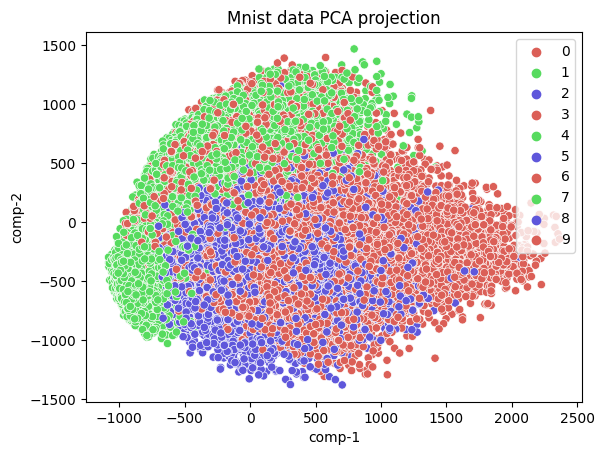

In [4]:
pca = PCA(n_components = 2, random_state = 1)
z = pca.fit_transform(x_train)
df = pd.DataFrame()
df["y"] = y_train
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

sns.scatterplot(x = "comp-1", y = "comp-2", hue = df.y.tolist(),
                palette = sns.color_palette("hls", 3),
                data = df).set(title = "Mnist data PCA projection")

In [5]:
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
pca = PCA(n_components = 10, random_state = 1)
pca.fit_transform(x_train)
pca_df = pd.DataFrame(pca.components_.T, columns = ["comp-1", "comp-2", "comp-3", "comp-4","comp-5","comp-6","comp-7","comp-8","comp-9","comp-10"])
pca_df.style.set_caption("PCA Loadings for first four PCs")

,comp-1,comp-2,comp-3,comp-4,comp-5,comp-6,comp-7,comp-8,comp-9,comp-10
0,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000
1,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
2,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
3,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
4,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000
5,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000
6,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000
7,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000
8,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
9,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000


In [7]:
pca.explained_variance_ratio_

array([0.09704664, 0.07095924, 0.06169089, 0.05389419, 0.04868797,
       0.04312231, 0.0327193 , 0.02883895, 0.02762028, 0.02356987])

In [8]:
sum = 0
for i in range(10):
    sum = sum + pca.explained_variance_ratio_[i]
sum    

0.4881496545315628

/tmp/ipykernel_15859/3985946429.py:8: UserWarning: 
The palette list has fewer values (3) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x = "comp-1", y = "comp-2", hue = df.y.tolist(),


[Text(0.5, 1.0, 'Mnist data SparsePCA projection')]

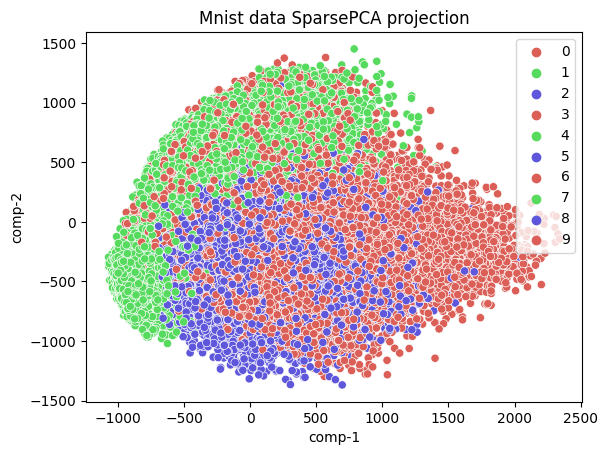

In [9]:
spca = SparsePCA(n_components = 2, random_state = 1)
z = spca.fit_transform(x_train)
df = pd.DataFrame()
df["y"] = y_train
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

sns.scatterplot(x = "comp-1", y = "comp-2", hue = df.y.tolist(),
                palette = sns.color_palette("hls", 3),
                data = df).set(title = "Mnist data SparsePCA projection")

In [10]:
spca = SparsePCA(n_components = 10 ,random_state = 1)
spca.fit_transform(x_train)
spca_df = pd.DataFrame(spca.components_.T, columns = ["comp-1", "comp-2", "comp-3", "comp-4","comp-5","comp-6","comp-7","comp-8","comp-9","comp-10"])
spca_df.style.set_caption("PCA Loadings for first four PCs")

,comp-1,comp-2,comp-3,comp-4,comp-5,comp-6,comp-7,comp-8,comp-9,comp-10
0,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
import numpy as np
t_spca = spca.transform(x_train)
p_spca = spca.components_.T
t_spca_qr = np.linalg.qr(t_spca) 
r = t_spca_qr[1]

# compute adjusted variance
variance = []
for i in range(10):
    variance.append(np.square(r[i][i]))
variance = np.array(variance)
e_variance = variance/np.sum(variance)

In [12]:
e_variance

array([0.19880505, 0.14536366, 0.12637696, 0.11040503, 0.09973981,
       0.08833828, 0.06702717, 0.05907808, 0.05658159, 0.04828437])

In [13]:
sum = 0
for i in range(10):
    sum = sum + e_variance[i]
sum    

0.9999999999999999

In [14]:
import numpy as np
from sklearn.decomposition import PCA

def JSPCA(X, alpha, beta, n_components, max_iter):
    """
     JSPCA algorithm for simultaneous sparse coding and principal component analysis.
    
     Parameters:
         X: numpy array of shape (n_samples, n_features)
             The input data matrix.
         alpha: float
             Sparsity parameter for the sparse coding step.
         beta: float
             Regularization parameter for the joint optimization problem.
         n_components: int
             Number of principal components to retain.
         max_iter: int
             Maximum number of iterations for the optimization.
    
     Returns:
         W: numpy array of shape (n_features, n_components)
             The projection matrix for the principal components.
         Z: numpy array of shape (n_samples, n_components)
             The sparse codes for the input data.
    """
    
    # Initialize the projection matrix and the sparse codes
    pca = PCA(n_components=n_components)
    W = pca.fit_transform(X)
    Z = np.zeros((X.shape[0], n_components))
    
    # Iterate until convergence
    for i in range(max_iter):

        print("outer loop", Z.shape, W.shape)
        
        # Update the sparse codes
        Z = _update_Z(X, W, alpha, beta)
        # Update the projection matrix
        # W = pca.fit_transform(np.dot(X.T, Z))
        print("After iter", W.shape, Z.shape)
    W = pca.fit_transform(np.dot(X.T, Z))
    return W, Z

def _update_Z(X, W, alpha, beta):
    """
    Update the sparse codes Z.
    
    Parameters:
        X: numpy array of shape (n_samples, n_features)
            The input data matrix.
        W: numpy array of shape (n_features, n_components)
            The projection matrix for the principal components.
        alpha: float
            Sparsity parameter for the sparse coding step.
        beta: float
            Regularization parameter for the joint optimization problem.
    
    Returns:
        Z: numpy array of shape (n_samples, n_components)
            The updated sparse codes.
    """
    
    n_samples, n_components = W.shape
    
    # Initialize the sparse codes
    Z = np.zeros((n_samples, n_components))
    
    print(W.shape, X.shape)
    for j in range(X[0].shape[0]):
        
        # Compute the coefficients for sparse coding
        Aj = np.dot(W.T, W) + beta * np.eye(n_components)
        print((W.T.shape, X[:, j].shape))
        bj = np.dot(W.T, X[:, j])
        Zj = np.zeros(n_components)
        for k in range(n_components):
            if bj[k] > alpha:
                Zj[k] = (bj[k] - alpha) / Aj[k, k]
            elif bj[k] < -alpha:
                Zj[k] = (bj[k] + alpha) / Aj[k, k]
        
        # Update the sparse codes
        Z[j] = Zj
    print("Z-shape", Z.shape)    
    return Z


outer loop (60000, 10) (60000, 10)
(60000, 10) (60000, 784)
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10, 60000), (60000,))
((10

/tmp/ipykernel_15859/2740507045.py:16: UserWarning: 
The palette list has fewer values (3) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x = "PC1", y = "PC2", hue = df.y.tolist(),


[Text(0.5, 1.0, 'Mnist data JSPCA projection')]

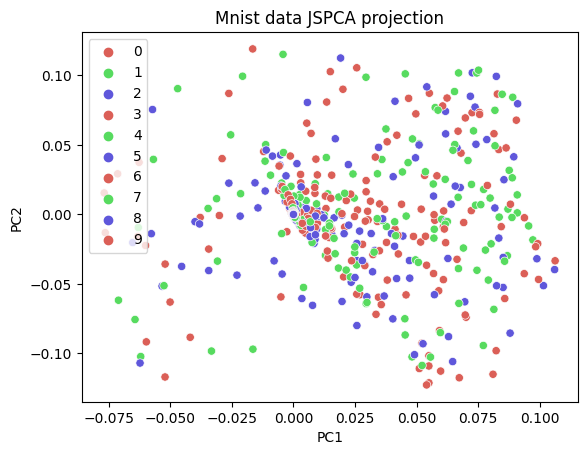

In [15]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Generate a synthetic dataset with 1000 samples and 50 features
X, _ = make_classification(n_samples=1000, n_features=50)

# Apply the JSPCA algorithm with alpha=1, beta=0.1, n_components=10, and max_iter=50
W, Z = JSPCA(x_train, alpha=1, beta=0.1, n_components= 10, max_iter=50)
#######################################################################################################################
df_1=pd.DataFrame()
df_1["y"] = y_train
df_1["PC1"] = Z[:, 0]
df_1["PC2"] = Z[:, 1]

sns.scatterplot(x = "PC1", y = "PC2", hue = df.y.tolist(),
                palette = sns.color_palette("hls", 3),
                data = df_1).set(title = "Mnist data JSPCA projection")

# Plot the first two principal components
#plt.scatter(Z[:, 0], Z[:, 1])
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.show()


In [16]:
Z

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
import numpy as np
t_Jspca = Z
t_Jspca_qr = np.linalg.qr(t_Jspca) 
r_1 = t_Jspca_qr[1]

# compute adjusted variance
variance = []
for i in range(5):
    variance.append(np.square(r_1[i][i]))
variance = np.array(variance)
variance/np.sum(variance)

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [18]:
t_Jspca_qr

(array([[ 0.00000000e+00, -2.08166817e-17,  3.98986399e-17, ...,
         -2.42861287e-17,  2.42861287e-17, -8.32667268e-17],
        [-0.00000000e+00,  0.00000000e+00,  5.12281349e-18, ...,
          2.37975594e-17, -7.55764221e-17,  9.54325593e-18],
        [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
         -2.17812675e-17, -2.58461801e-17, -1.67714885e-17],
        ...,
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]]),
 array([[-9.99999999e-01, -1.24541432e-10,  1.41879617e-10,
          2.41203523e-10,  1.49049870e-10,  2.43333168e-10,
          1.20136298e-10, -1.76640508e-10,  4.19192569e-10,
          2.22927014e-10],
        [ 0.00000000e+

In [19]:
t_Jspca

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
pd.DataFrame(Z)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
pd.DataFrame(W)

,0,1,2,3,4,5,6,7,8,9
0,-560.513256,-16.993969,15.453634,4.870556,4.023078,-4.379465,-3.156554,4.654436,2.612864,-1.947071
1,-560.513256,-16.993969,15.453634,4.870556,4.023078,-4.379465,-3.156554,4.654436,2.612864,-1.947071
2,-560.513256,-16.993969,15.453634,4.870556,4.023078,-4.379465,-3.156554,4.654436,2.612864,-1.947071
3,-560.513256,-16.993969,15.453634,4.870556,4.023078,-4.379465,-3.156554,4.654436,2.612864,-1.947071
4,-560.513256,-16.993969,15.453634,4.870556,4.023078,-4.379465,-3.156554,4.654436,2.612864,-1.947071
...,...,...,...,...,...,...,...,...,...,...
779,-560.513256,-16.993969,15.453634,4.870556,4.023078,-4.379465,-3.156554,4.654436,2.612864,-1.947071
780,-560.513256,-16.993969,15.453634,4.870556,4.023078,-4.379465,-3.156554,4.654436,2.612864,-1.947071
781,-560.513256,-16.993969,15.453634,4.870556,4.023078,-4.379465,-3.156554,4.654436,2.612864,-1.947071
782,-560.513256,-16.993969,15.453634,4.870556,4.023078,-4.379465,-3.156554,4.654436,2.612864,-1.947071
